# 차원축소

## 왜 하는가?

1.  observation을 줄이는 것. $$X_1, \cdots, X_n ⇒ \overline{X}$$
2.  variable을 줄이는 것. 우리가 가지고 있는 데이터 ⇒ 모두 matrix 관심 있는 데이터 = 수치형 데이터. binary면 좀 애매하긴 하다. 이때 가장 많이 쓰이는 통계적 차원축소 기법은 다음과 같다.

-   주성분분석(PCA), 특이값분해(SVD)

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import pdist
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from scipy.linalg import svd


# 행렬 데이터와 패턴

## 데이터 생성 & 패턴 추가

40개의 row와 10개의 column을 가진 데이터 생성. 데이터를 시각화하고, 히트맵을 이용해 클러스터링을 한다.

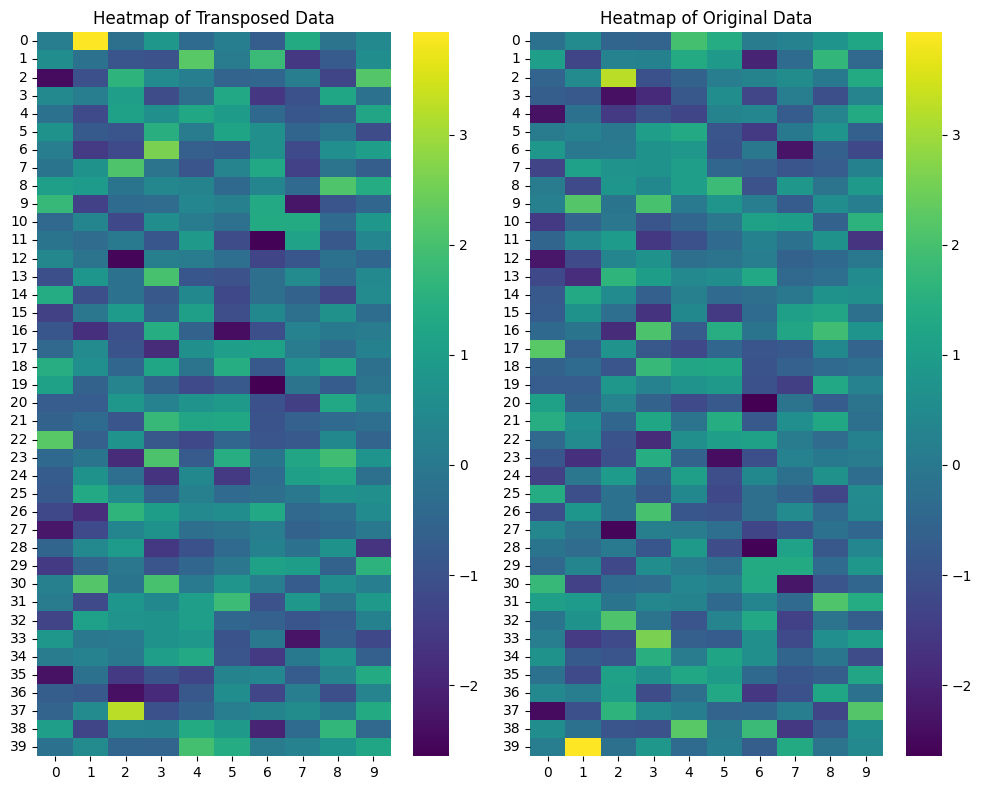

In [58]:
# 데이터 생성
np.random.seed(12345)
dataMat = np.random.randn(40, 10)

# 데이터 시각화 및 히트맵 그리기
plt.figure(figsize=(10, 8))

# 데이터 전치 후 시각화
plt.subplot(1, 2, 1)
sns.heatmap(dataMat[::-1, :], cmap='viridis')
plt.title('Heatmap of Transposed Data')

# 원본 데이터 시각화
plt.subplot(1, 2, 2)
sns.heatmap(dataMat, cmap='viridis')
plt.title('Heatmap of Original Data')

plt.tight_layout()
plt.show()

특정한 패턴이 없으므로, 행렬 데이터에 임의로 패턴을 추가해보자.

1.  시드넘버를 678910으로 고정한다.
2.  행에 패턴을 넣는 것이므로 `for()`문을 쓰되, 그 길이를 40으로 한다.
3.  `coinflip` 변수를 만들고, 해당 변수가 T일 때 패턴을 넣는다.
4.  패턴은 `rep(c(0, 3), each=5)` 로 만들고 각 열에 더한다.


In [59]:
# 데이터 수정
np.random.seed(678910)
for i in range(40):
    coinflip = np.random.binomial(1, 0.5)
    
    # coin이 앞면일 경우, 패턴 추가
    if coinflip:
        dataMat[i, :] += np.tile([0, 3], 5)


인제 패턴이 들어간 상태에서의 행렬을 시각화해보자.   
히트맵을 그리고, 클러스터링도 해본다.  

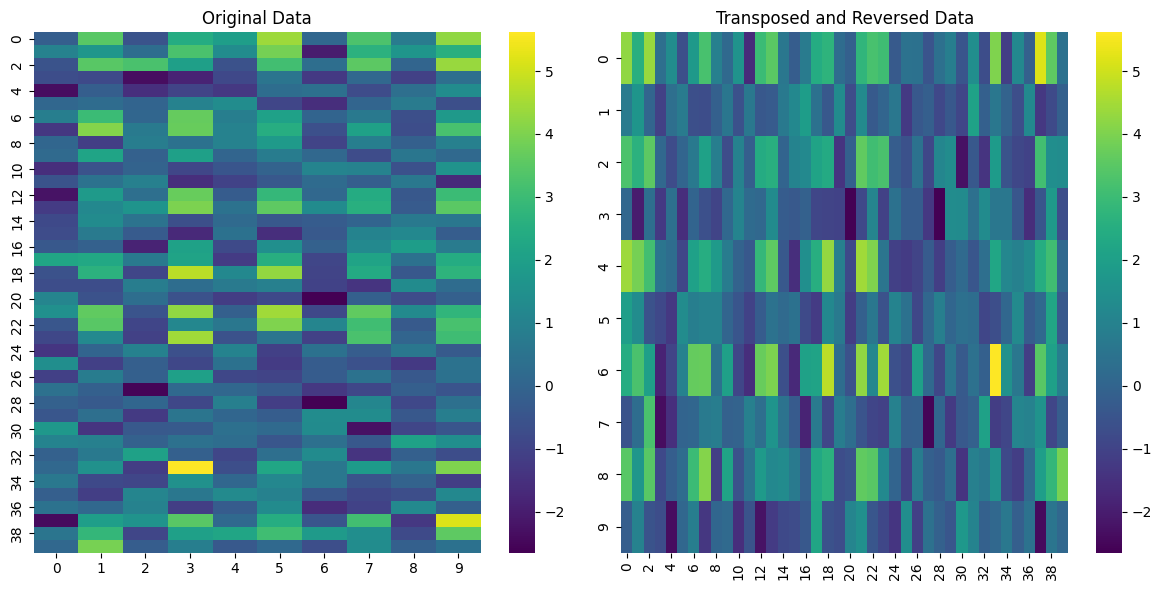

In [60]:
# 히트맵 그리기
plt.figure(figsize=(12, 6))

# 원본 데이터의 히트맵
plt.subplot(1, 2, 1)
sns.heatmap(dataMat, cmap='viridis', cbar=True)
plt.title('Original Data')

# 데이터 전치 및 역순
dataMat_transposed = dataMat.T
dataMat_transposed_reversed = dataMat_transposed[::-1]

# 전치된 데이터의 히트맵
plt.subplot(1, 2, 2)
sns.heatmap(dataMat_transposed_reversed, cmap='viridis', cbar=True)
plt.title('Transposed and Reversed Data')

plt.tight_layout()
plt.show()


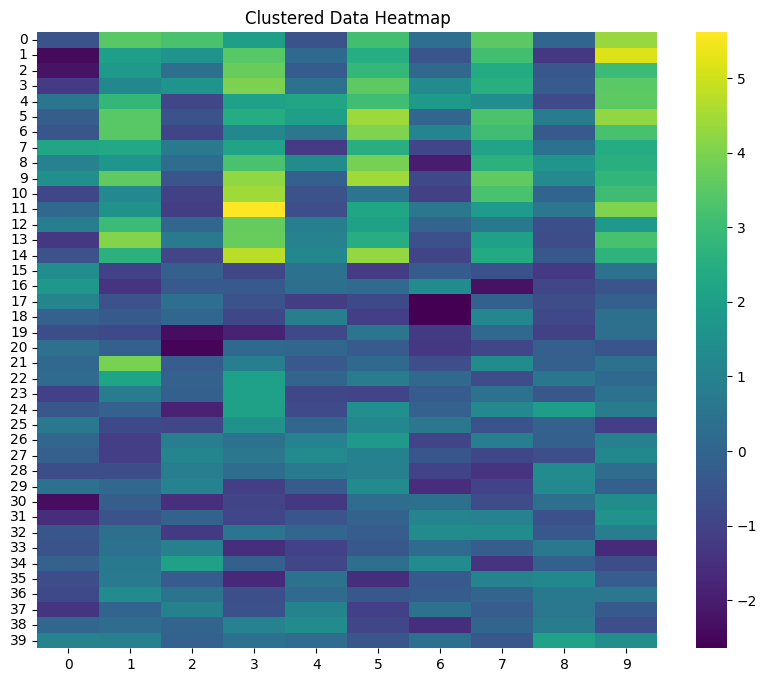

In [61]:
# 클러스터링
distance_matrix = pdist(dataMat, 'euclidean')

# 계층적 클러스터링
linkage_matrix = linkage(distance_matrix, method='ward')

# 클러스터링 결과로 데이터를 정렬
dendrogram_result = dendrogram(linkage_matrix, no_plot=True)
ordered_indices = leaves_list(linkage_matrix)
ordered_data = dataMat[ordered_indices, :]

# 히트맵을 정렬된 데이터로 다시 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(dataMat[ordered_indices, :], cmap='viridis', cbar=True)
plt.title('Clustered Data Heatmap')
plt.show()

## 행과 열의 패턴

행과 열의 평균을 확인해서 패턴이 잘 들어갔는지를 자세히 살펴보자.

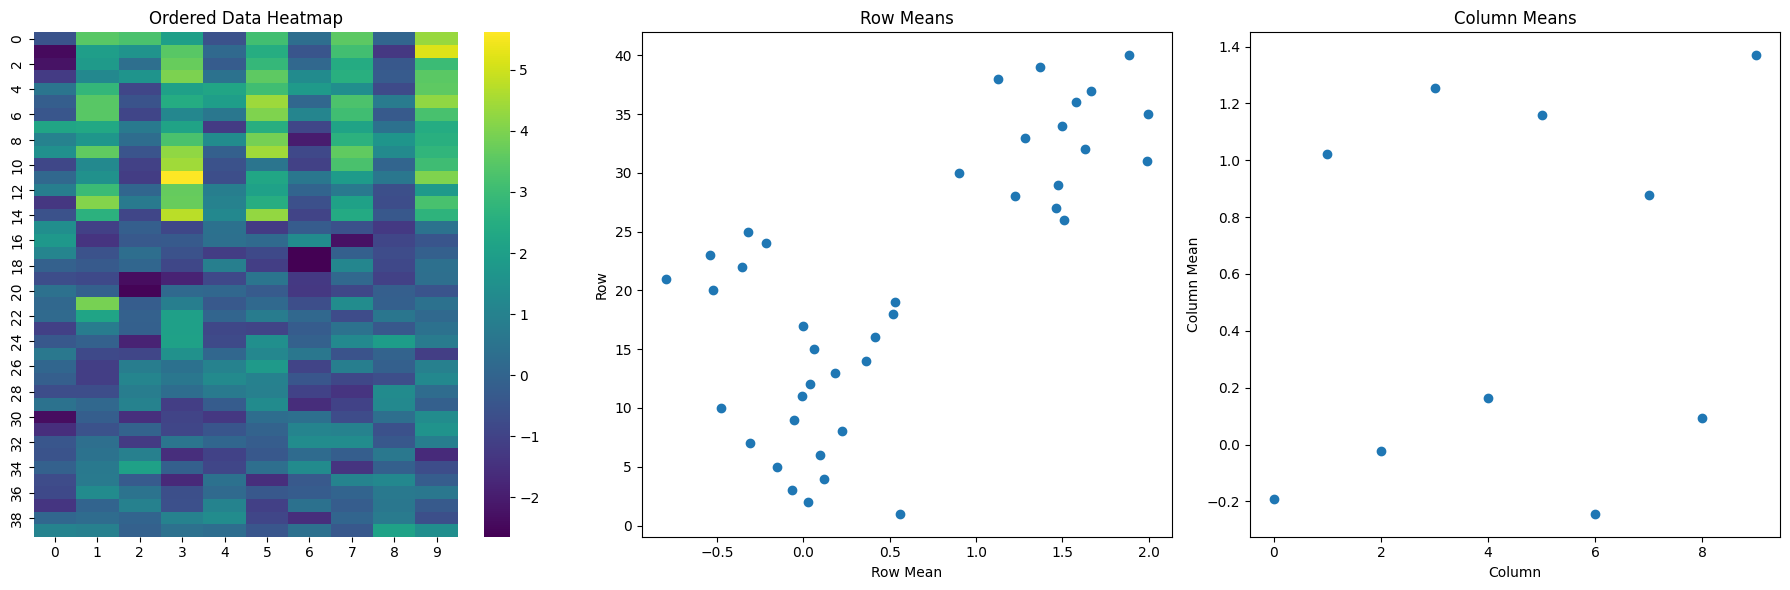

In [62]:
# 패턴 찾기 및 시각화
plt.figure(figsize=(18, 6))

# 1. 정렬된 데이터의 히트맵
plt.subplot(1, 3, 1)
sns.heatmap(ordered_data, cmap='viridis', cbar=True)
plt.title('Ordered Data Heatmap')

# 2. 행 평균 플롯
plt.subplot(1, 3, 2)
plt.plot(np.mean(ordered_data, axis=1), range(40, 0, -1), 'o')
plt.xlabel('Row Mean')
plt.ylabel('Row')
plt.title('Row Means')

# 3. 열 평균 플롯
plt.subplot(1, 3, 3)
plt.plot(np.mean(ordered_data, axis=0), 'o')
plt.xlabel('Column')
plt.ylabel('Column Mean')
plt.title('Column Means')

plt.tight_layout()
plt.show()

-   행과 열로 각각 2개씩 나눠지게 된다.
-   행(row) 기준: 아래 vs 위. 모양 자체는 정규분포
    -   아래 : 평균 0
    -   위 : 평균 3
-   열(column) 기준 : 아래 vs 위. 모양 자체는 이항분포
    -   처음 5개 = 평균 0
    -   나머지 다섯 개 = 평균 약 1.8

데이터를 만들 때를 생각해보자.

-   기본적으로 정규분포를 사용: `rnorm()`
-   패턴을 넣을 때(데이터의 절반) 이항분포를 사용: `rbinom()`
-   저런 모양이 나온 이유라고 할 수 있다.

실제 데이터는 이것보다 더 다양한 패턴이 나타날 수 있기 때문에

**패턴들을 구분짓는 방법**이 필요함!

가장 좋은 방법은 패턴을 나타내는 데이터만 뽑아내는 것이라고 할 수 있다!

이는 원 데이터에서 차원을 축소해서 저차원 데이터를 얻는 것과 같다.

-   하나의 방법은 변수들 중 어떤 것은 버리고, 다른 것은 살린다.
    -   상관관계를 분석하는 방법. 그런데 모든 변수들을 다 하긴 어렵다.
-   다른 방법은 새로운 변수(feature)를 만드는 것이다.
    -   새 변수는 서로 uncorrelated 되어야 한다.
    -   또한 최대한 많은 분산을 표현해야 한다.
-   이때 사용하는 것이 PCA와 FA라고 할 수 있다.

# PCA: 주성분분석
PCA란? 데이터 특성을 나타내는 공분산행렬을 분해해 일부를 얻어내는 것!

사영(projection)을 통해 데이터의 위치 변환 후 변하지 않는 축만 뽑는다.

이러한 과정은 SVD (특이값 분해)를 통해 데이터를 압축하는 것과 같다.

## PCA의 원리

1.  표본 공분산행렬 A를 만든다.
2.  A를 대각행렬 L로 만든다.
3.  A의 대각원소 중 일부를 뽑아서 $A_d$를 만든다.
4.  원래 데이터인 $X_c$와 $A_d$를 곱해서 $Z_d$를 만든다.

## PCA의 특징

-   변수들 간의 선형관계가 강해야 PCA는 잘 작동한다.
-   X들이 correlation이 강하지 않으면 의미가 없다.
-   설문조사처럼 모든 변수들이 같은 수준으로 점수화가 된 경우에는 공분산 행렬을 사용
-   그러나 변수들의 scale이 서로 많이 다른 경우에는 값이 큰 특정 변수가 전체적인 경향을 좌우
    -   따라서 이때는 상관계수 행렬을 사용하여 추출해야 한다.
    -   R에서는 `prcomp(scale=T)` 로 만들면 됨.
    -   대부분의 예시에서 상관계수 행렬과 공분산 행렬을 동시에 놓고 비교!
-   축소한 만큼의 손실(표현하지 못하는 분산)은 당연히 발생한다.


## 예시 1: 패턴 1개

svd를 해 근사 데이터를 만들고, 원래 데이터와 근사 데이터를 비교해보자.

svd를 통한 근사 데이터를 만들 떄, U와 V의 1st 성분만 뽑아낸다.


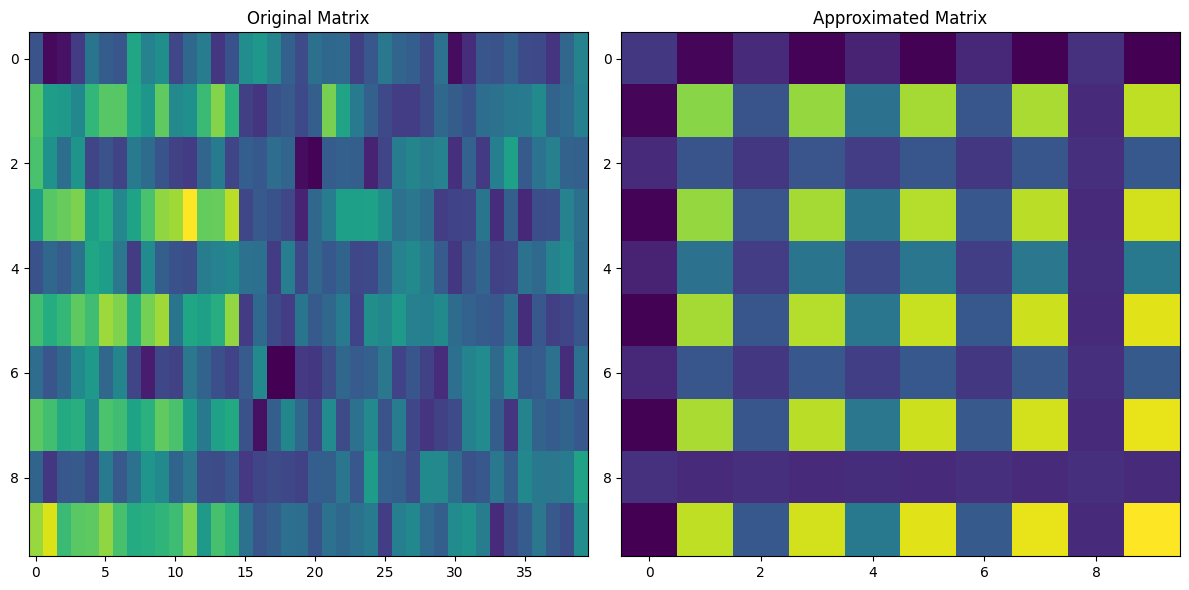

In [63]:
# PCA 실행
svd = TruncatedSVD(n_components=1)
scaled_data = scale(ordered_data)  # 스케일링
svd.fit(scaled_data)
approx = np.outer(svd.components_[0], svd.components_[0])

# 시각화
plt.figure(figsize=(12, 6))

# 원본 데이터
plt.subplot(1, 2, 1)
plt.imshow(ordered_data.T, aspect='auto', cmap='viridis')
plt.title('Original Matrix')

# 근사 데이터
plt.subplot(1, 2, 2)
plt.imshow(approx.T, aspect='auto', cmap='viridis')
plt.title('Approximated Matrix')

plt.tight_layout()
plt.show()

### 설명된 분산

이때, 데이터의 첫 번째 분산이 전체 분산을 얼마나 반영하는지 살펴보자.

1.  기존 데이터를 0과 1로만 이뤄진 데이터로 바꾼다.
2.  “특이값(전체 분산)” vs “설명된 분산의 비율” 비교
3.  시각화

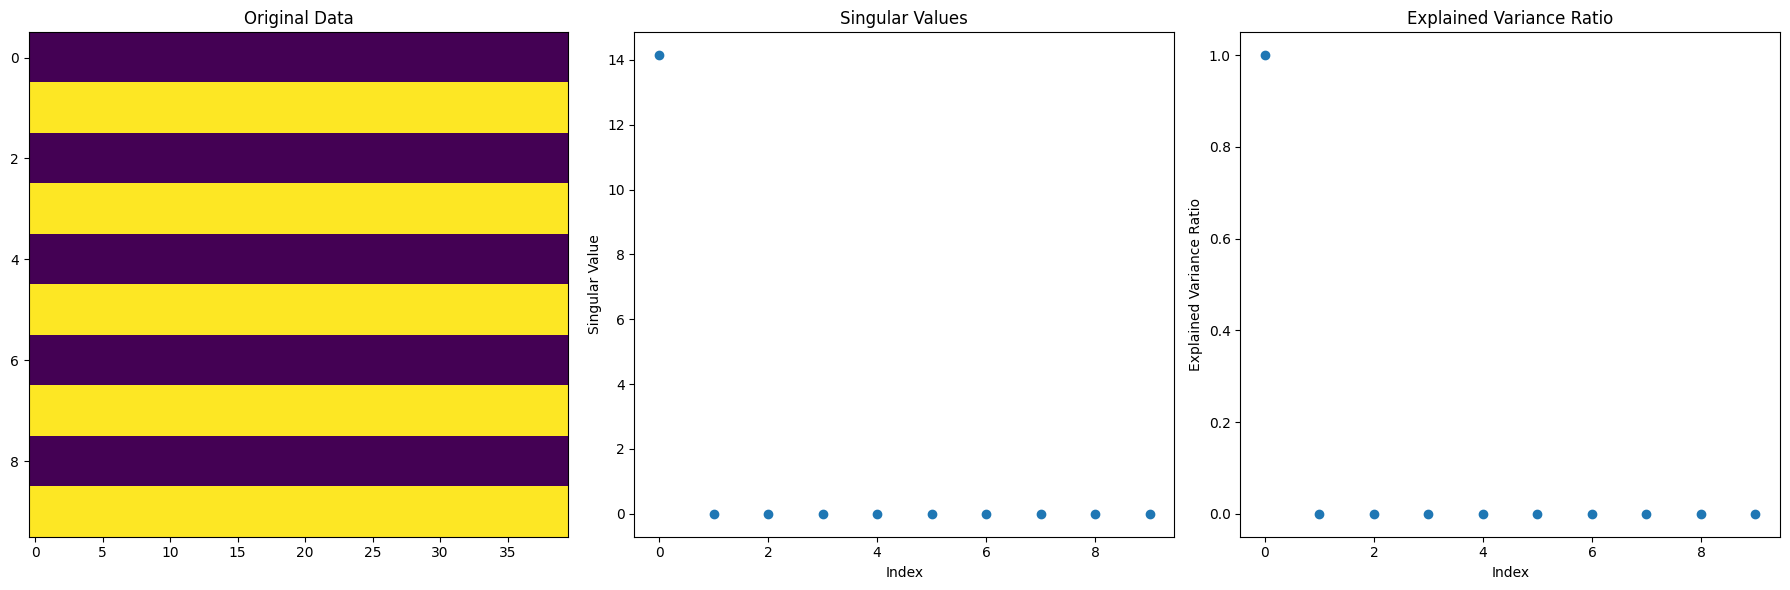

In [64]:
# 데이터 생성
ordered = np.random.randn(40, 10)  # 예제 데이터 (이전에 생성한 데이터 사용)
for i in range(40):
    if np.random.binomial(1, 0.5):
        ordered[i, :] += np.tile([0, 3], 5)

# 0, 1로 이루어진 데이터 만들기
const = np.zeros_like(ordered)
for i in range(ordered.shape[0]):
    const[i, :] = np.tile([0, 1], 5)

# SVD 수행
svd2 = np.linalg.svd(const, full_matrices=False)
singular_values = svd2[1]  # SVD의 특이값

# 데이터 비교 함수
def compare_data(const, singular_values):
    plt.figure(figsize=(18, 6))
    
    # 원본 데이터 시각화
    plt.subplot(1, 3, 1)
    plt.imshow(const.T, aspect='auto', cmap='viridis')
    plt.title('Original Data')

    # 특이값 시각화
    plt.subplot(1, 3, 2)
    plt.plot(singular_values, 'o')
    plt.xlabel('Index')
    plt.ylabel('Singular Value')
    plt.title('Singular Values')

    # 설명된 분산 비율 시각화
    plt.subplot(1, 3, 3)
    explained_variance_ratio = singular_values**2 / np.sum(singular_values**2)
    plt.plot(explained_variance_ratio, 'o')
    plt.xlabel('Index')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio')

    plt.tight_layout()
    plt.show()

compare_data(const, singular_values)

### 비교: PCA vs SVD

이렇게 만들어진 SVD의 특이값 = PCA의 주성분!

In [65]:
# 데이터 표준화
ordered_scaled = (ordered - np.mean(ordered, axis=0)) / np.std(ordered, axis=0)

# PCA 수행
pca = PCA(n_components=10)
pca.fit(ordered_scaled)

# SVD 수행
u, s, vt = svd(ordered_scaled, full_matrices=False)
v = vt.T  # SVD에서의 우측 특이 벡터

# 그래프로 비교하기
plt.figure(figsize=(8, 6))
plt.scatter(pca.components_[0, :], v[:, 0], c='blue', label='Component 1 vs. Right Singular Vector 1')
plt.xlabel('Principal Component 1')
plt.ylabel('Right Singular Vector 1')
plt.title('PCA Component vs. SVD Right Singular Vector')

# y=x 선 추가
plt.plot([-1, 1], [-1, 1], color='red', linestyle='--', label='y=x')

plt.legend()
plt.grid(True)
plt.show()

TypeError: 'TruncatedSVD' object is not callable

## 예시 2: 패턴 2개

패턴이 2개 이상인 데이터 역시 svd를 통해 패턴을 발견할 수 있다.

먼저 패턴 2개를 넣은 새 데이터를 만들어보자.

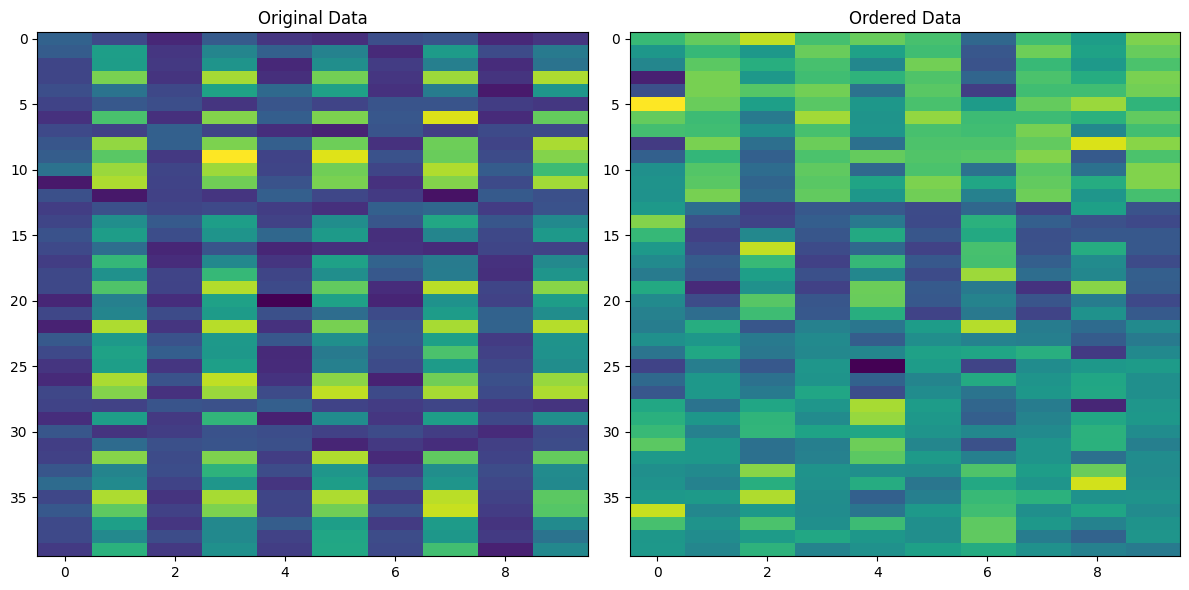

In [ ]:
# 데이터 생성
np.random.seed(678910)
dataMat2 = np.random.randn(40, 10)

# 패턴 추가
for i in range(40):
    coinflip1 = np.random.binomial(1, 0.5)
    coinflip2 = np.random.binomial(1, 0.5)
    if coinflip1:
        dataMat2[i, :] += np.tile([0, 5], 5)
    if coinflip2:
        dataMat2[i, :] += np.tile([0, 5], 5)

# 데이터 표준화
scaler = StandardScaler()
dataMat2_scaled = scaler.fit_transform(dataMat2)

# 클러스터링 및 행 재정렬
dist_matrix = pdist(dataMat2_scaled)
linkage_matrix = linkage(dist_matrix, method='ward')
dendro = dendrogram(linkage_matrix, no_plot=True)
ordered2 = dataMat2_scaled[dendro['leaves'], :]

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(dataMat2, aspect='auto', cmap='viridis')
plt.title('Original Data')

plt.subplot(1, 2, 2)
plt.imshow(ordered2, aspect='auto', cmap='viridis')
plt.title('Ordered Data')
plt.tight_layout()
plt.show()

데이터와 각 패턴의 모습은 다음과 같다.

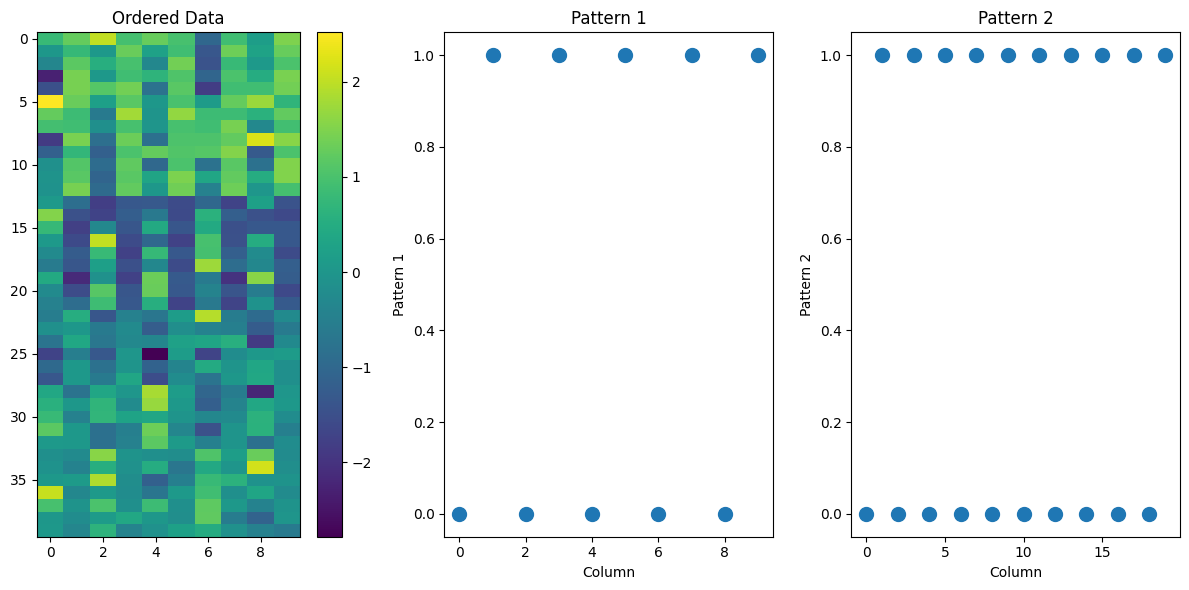

In [ ]:
# 클러스터링 및 행 재정렬
dist_matrix = pdist(dataMat2_scaled)
linkage_matrix = linkage(dist_matrix, method='ward')
dendro = dendrogram(linkage_matrix, no_plot=True)
ordered2 = dataMat2_scaled[dendro['leaves'], :]

# 그래픽 설정
plt.figure(figsize=(12, 6))

# 1. 데이터 히트맵
plt.subplot(1, 3, 1)
plt.imshow(ordered2, aspect='auto', cmap='viridis')
plt.title('Ordered Data')
plt.colorbar()

# 2. 패턴 1 플로팅
plt.subplot(1, 3, 2)
plt.plot(np.tile([0, 1], 5), 'o', markersize=10)
plt.xlabel('Column')
plt.ylabel('Pattern 1')
plt.title('Pattern 1')

# 3. 패턴 2 플로팅
plt.subplot(1, 3, 3)
plt.plot(np.tile([0, 1], 10), 'o', markersize=10)
plt.xlabel('Column')
plt.ylabel('Pattern 2')
plt.title('Pattern 2')

plt.tight_layout()
plt.show()

새 데이터로 `svd3`를 만들고, 시각화해보자.

첫 번째 오른쪽 특이값벡터, 두 번째 특이값벡터의 plot을 그리면 된다.

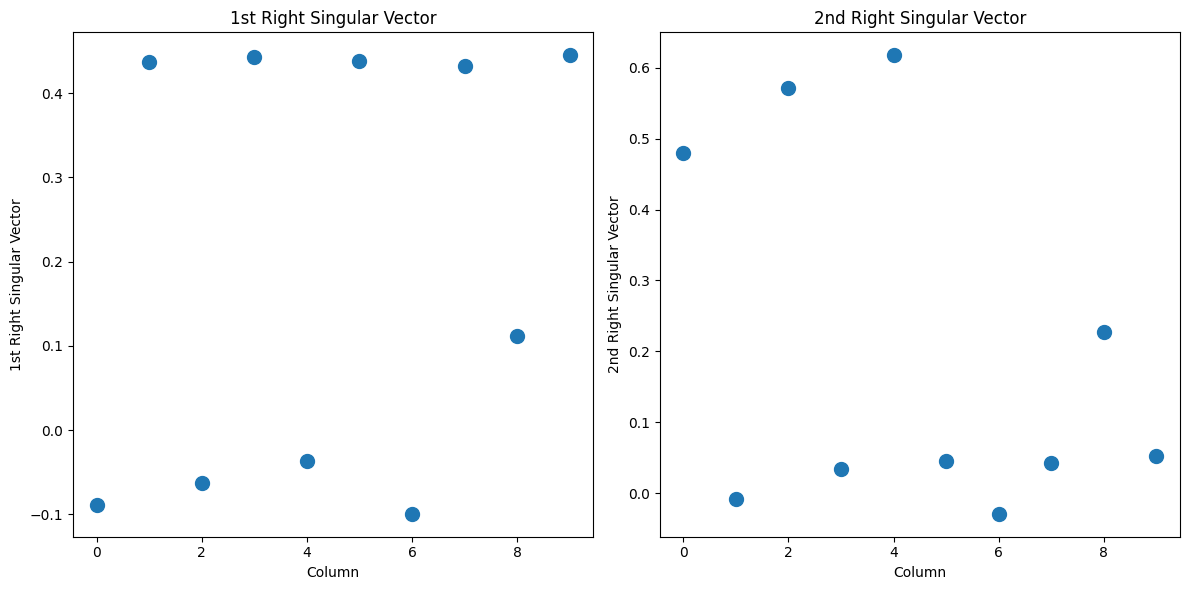

In [ ]:
# SVD 실행
U, S, Vt = svd(dataMat2_scaled, full_matrices=False)
V = Vt.T  # Vt는 V의 전치행렬

# 그래픽 설정
plt.figure(figsize=(12, 6))

# 1. 1차 오른쪽 특이 벡터
plt.subplot(1, 2, 1)
plt.plot(V[:, 0], 'o', markersize=10)
plt.xlabel('Column')
plt.ylabel('1st Right Singular Vector')
plt.title('1st Right Singular Vector')

# 2. 2차 오른쪽 특이 벡터
plt.subplot(1, 2, 2)
plt.plot(V[:, 1], 'o', markersize=10)
plt.xlabel('Column')
plt.ylabel('2nd Right Singular Vector')
plt.title('2nd Right Singular Vector')

plt.tight_layout()
plt.show()

### 설명된 분산

여기서도 설명된 분산의 비율을 확인해보자.

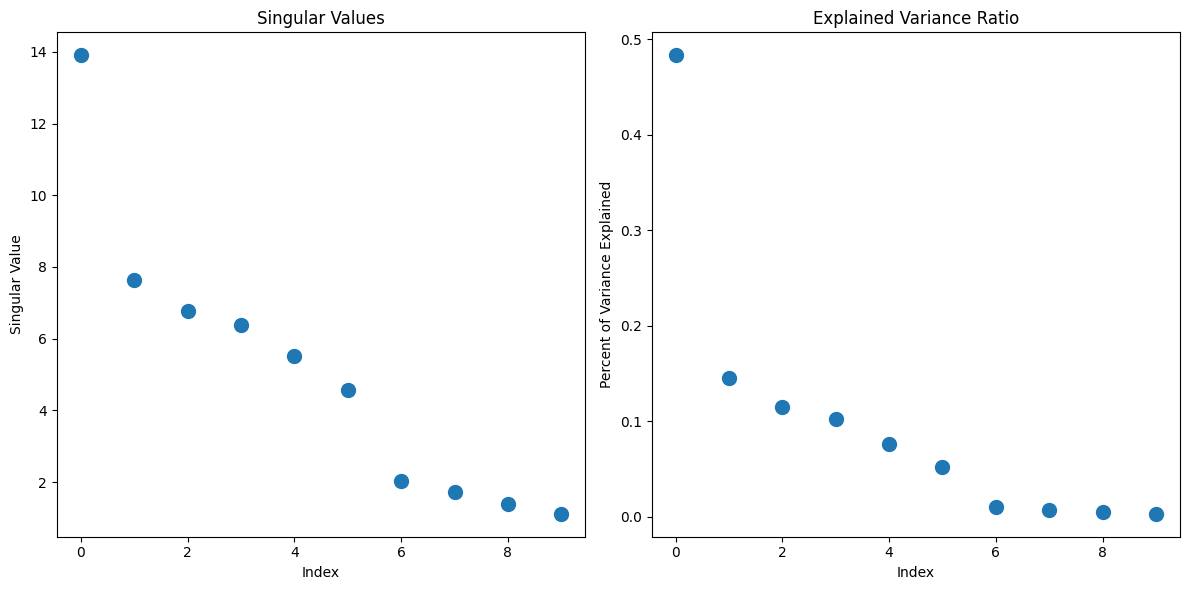

In [ ]:
# 설명된 분산 비율 계산
singular_values = S
explained_variance_ratio = (singular_values**2) / np.sum(singular_values**2)

# 그래픽 설정
plt.figure(figsize=(12, 6))

# 1. 특이값
plt.subplot(1, 2, 1)
plt.plot(singular_values, 'o', markersize=10)
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values')

# 2. 설명된 분산 비율
plt.subplot(1, 2, 2)
plt.plot(explained_variance_ratio, 'o', markersize=10)
plt.xlabel('Index')
plt.ylabel('Percent of Variance Explained')
plt.title('Explained Variance Ratio')

plt.tight_layout()
plt.show()

## 예시 3: 얼굴 데이터

얼굴 데이터를 SVD해서 원래 결과와 비슷한지 확인해보자.

이는 통계 데이터를 PCA하는 것 같은 과정이다.

-   얼굴데이터 : 일부만 시각화 → 전체 데이터와 비슷
-   통계데이터 : 일부만 뽑아내기 → 전체 데이터와 비슷.

얼굴 데이터를 살펴보고, scree plot을 그려보자.

In [ ]:
from rpy2 import robjects
from rpy2.robjects import pandas2ri

# R에서 .rda 파일 로드
robjects.r['load']("../../dataset/face.rda")

# 'faceData' 객체를 R에서 Python으로 가져오기
faceData = robjects.r['faceData']

# R의 데이터 프레임을 Pandas DataFrame으로 변환
pandas2ri.activate()
faceData_df = pandas2ri.rpy2py(faceData)


In [ ]:
# 데이터 전처리 및 SVD 수행
dataMat = np.array(faceData_df)
dataMat_scaled = (dataMat - np.mean(dataMat, axis=0)) / np.std(dataMat, axis=0)  # 데이터 표준화

# SVD 수행
U, S, Vt = svd(dataMat_scaled, full_matrices=False)
explained_variance_ratio = (S**2) / np.sum(S**2)

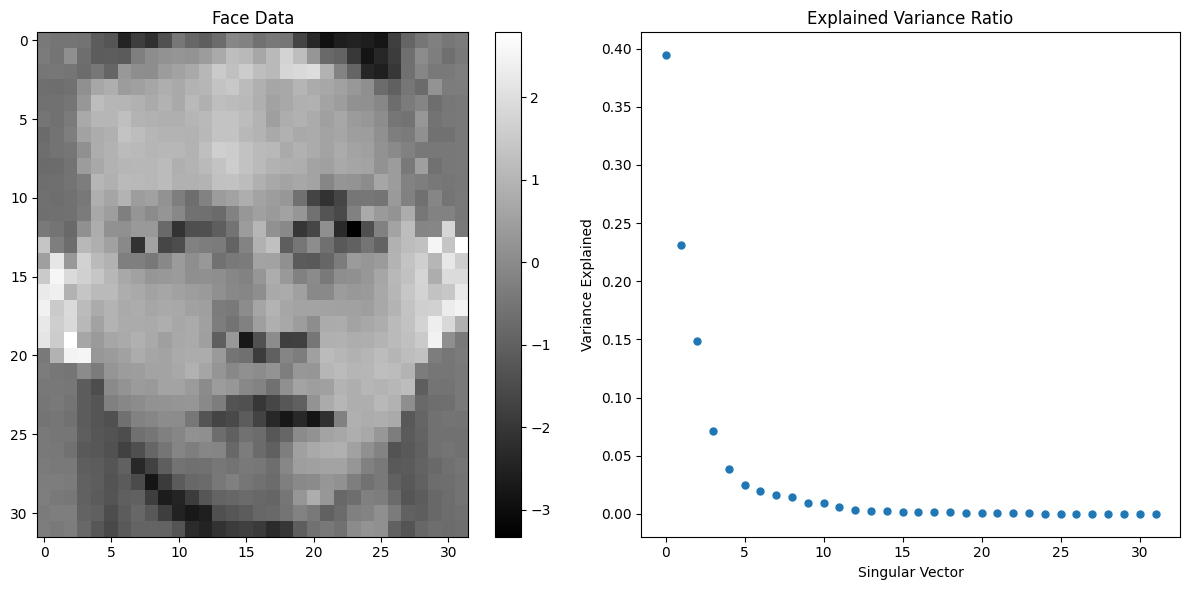

In [ ]:
# 시각화
plt.figure(figsize=(12, 6))

# 얼굴 이미지 보기
plt.subplot(1, 2, 1)
plt.imshow(dataMat_scaled, aspect='auto', cmap='gray')
plt.title('Face Data')
plt.colorbar()

# 설명된 분산 비율
plt.subplot(1, 2, 2)
plt.plot(explained_variance_ratio, 'o', markersize=5)
plt.xlabel('Singular Vector')
plt.ylabel('Variance Explained')
plt.title('Explained Variance Ratio')

plt.tight_layout()
plt.show()

특이값의 갯수를 다르게 해보며 얼굴이 원래와 비슷해지는지 보자.

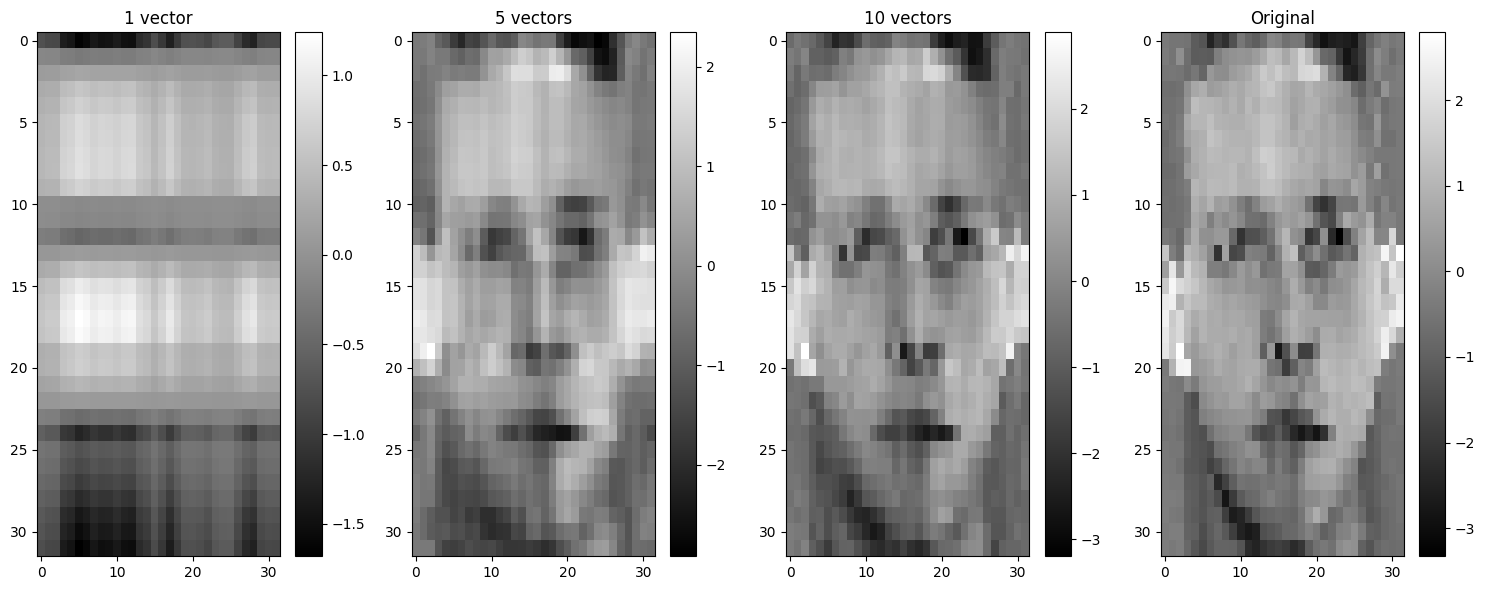

In [ ]:
# 다양한 근사 행렬 생성
approx1 = np.outer(U[:, 0], Vt[0, :]) * S[0]
approx5 = np.dot(U[:, :5], np.diag(S[:5])).dot(Vt[:5, :])
approx10 = np.dot(U[:, :10], np.diag(S[:10])).dot(Vt[:10, :])

# 얼굴 데이터 시각화
plt.figure(figsize=(15, 6))

plt.subplot(1, 4, 1)
plt.imshow(approx1, aspect='auto', cmap='gray')
plt.title("1 vector")
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(approx5, aspect='auto', cmap='gray')
plt.title("5 vectors")
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(approx10, aspect='auto', cmap='gray')
plt.title("10 vectors")
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(dataMat_scaled, aspect='auto', cmap='gray')
plt.title("Original")
plt.colorbar()

plt.tight_layout()
plt.show()

# FA: 요인분석

-   목적은 차원축소이고, outcome이 여러개.
-   기존 변수 m개의 정보를 담을 수 있는 새 변수 n개를 만든다.
    -   기존 변수에 무언가를 더하고 곱해서 새 변수를 만든다.
    -   ex. 국, 수, 사, 과, 영 ⇒ 암기력, 학습능력 측정.

## FA의 원리

$$
X_{i1} - \mu_{i1} = \lambda_{11}f_{i1} + \cdots + \lambda_{11}f_{id} + \epsilon_{i1} \\ \vdots \\ X{ip} - \mu_{ip} = \lambda_{p1}f_{i1} + \cdots + \lambda_{p1}f_{id} + \epsilon\_{ip}
$$

$$
\mathbf{X - \mu = \Lambda f + e}
$$

요인분석 식을 만들어보면, 다음과 같은 변수 4개가 존재한다.

-   $X_{ij}$ : 관찰변수 = **줄여야 하는 기존 변수**.
-   $f_{in}$ : 잠재변수 (common factors), 요인, 인자 = **만들어야 하는 새 변수**
    -   아직 무슨 값을 가졌는지 모르니까 분포를 가진다.
-   $\lambda_{ij}$ : 요인적재량 (factor loadings) = 잠재변수가 관찰변수에 미치는 **가중치**.
    -   보통 0 아니면 1 이라고 가정한다.
-   $\epsilon_{ij}$ : 특정변수 (specific factors)
    -   서로 상관관계가 없고, 잠재변수하고도 상관관계가 없다.

이때, 새 변수(관찰변수)의 분산 $Var(X_{i})$은 얼마일까?

$$
\begin{align*}
Var(X_{i}) &= 
{\lambda_1}^2~var(f_1) + \cdots
{\lambda_n}^2~var(f_n) +
{\sigma_j}^2
\\[10pt]
&= 
{\lambda_1}^2 + \cdots
{\lambda_n}^2 +
{\sigma_j}^2
\end{align*}
$$

## 행렬형태
모든 변수를 다 담는 행렬 형태로 다시 써보면 다음과 같다.

$$
\begin{align*}
E(\mathbf{x}) &= 
\mathbf{\mu + \Lambda}E(\mathbf{f}) + E(\mathbf{\epsilon})
\\
&= \mathbf{\mu}
\\[10pt]

Var(\mathbf{x}) &= 
\mathbf{\Lambda \cdot v(f_i) \cdot \Lambda^t} +
var(\mathbf{\epsilon_i})
\\
&= \mathbf{\Lambda  \cdot \Lambda^t + \psi}
\\[10pt]

S &= \mathbf{\hat\Lambda \cdot \hat\Lambda^t + \hat\psi}
\end{align*}

$$

공분산행렬 S에서 우리가 모르는 변수 2개를 보자.

1.  오차변수의 공분산행렬 $\hat \psi$
    -   $\hat \psi$을 대각행렬(diagonal matrix)라고 가정.
    -   왜? 그래야 $\mathbf{x}$들끼리의 분산을 $\mathbf{\Lambda}$로 설명 가능.
2.  요인행렬 $\mathbf{\hat\Lambda}$
    -   요인적재량을 모은 것으로, 변수 간의 상관관계를 설명한다.
    -   문제는 $\mathbf{f_i}$도 일종의 확률변수. 만약 $\lambda \cdot R \cdot R^{-1} \cdot \mathbf{f_i}$를 하면, 값이 달라짐. 따라서 값이 한개가 아님. 이 상태에서는 관찰변수들과 잠재변수들 사이의 관계가 명확하지 않음.
    -   따라서 이를 회전시켜야 함. (= 분산 재분배)

**요인행렬의 회전**

1.  Varimax (직교회전)
    -   요인 간 상관성이 없다고 가정
    -   좌표축의 각도를 정확히 90도로 유지하여 회전
    -   요인행렬 각 열의 분산을 최대화하는 기법
    -   큰 값은 더 크게, 작은 값은 더 작게
2.  Promax (사각회전)
    -   요인 간 상관성이 있다고 가정
    -   좌표축의 각도가 90도가 되지 않도록 회전
    -   추출한 요인들 간 상관관계를 다시 설명해야 함.
    -   요인 간 군집관계를 잘 설명.


## 예제 1: 주식 데이터

**데이터 불러오기 & 편집**

1.  데이터를 불러온다.
2.  상관계수 행렬을 만들어준다. `prcomp(~~, scale = T)` 로 해줘도 된다.

In [ ]:
# R에서 .RData 파일 로드
robjects.r['load']("../../dataset/stockreturns.RData")

# 'stocks' 객체를 R에서 Python으로 가져오기
stocks = robjects.r['stocks']

# R의 데이터 프레임을 Pandas DataFrame으로 변환
pandas2ri.activate()
stocks_df = pandas2ri.rpy2py(stocks)

# Pandas DataFrame을 numpy 배열로 변환
stocks_array = np.array(stocks_df)

# 표준화 계산
mean = np.mean(stocks_array, axis=0)
std_dev = np.std(stocks_array, axis=0)

# 표준화된 데이터 계산
mean = np.mean(stocks_array, axis=0)
std_dev = np.std(stocks_array, axis=0)
stocks_new = (stocks_array - mean) / std_dev

**PCA로 분석하기**

PCA 작업을 해주고, Scree Plot을 이용해 시각화를 시켜보자.

**Scree Plot 이란?**

-   PCA 분석 후 주성분 수를 선정하기 위해 쓰는 차트
-   고유값-주성분의 분산 변화를 보여준다.
-   고유값 변화율이 완만해지는 부분이 필요한 주성분의 수이다.


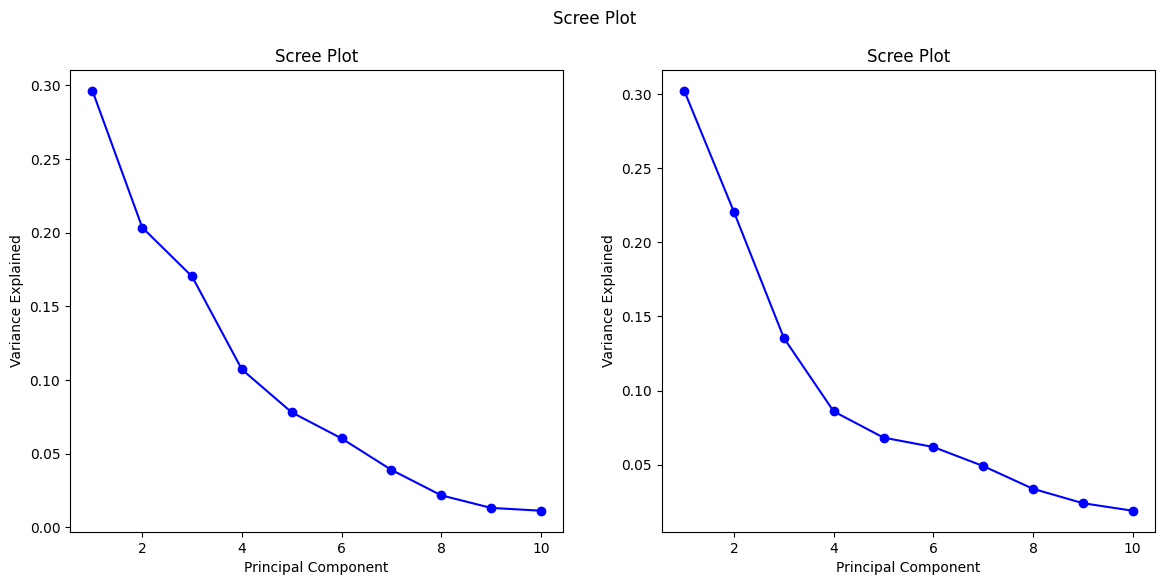

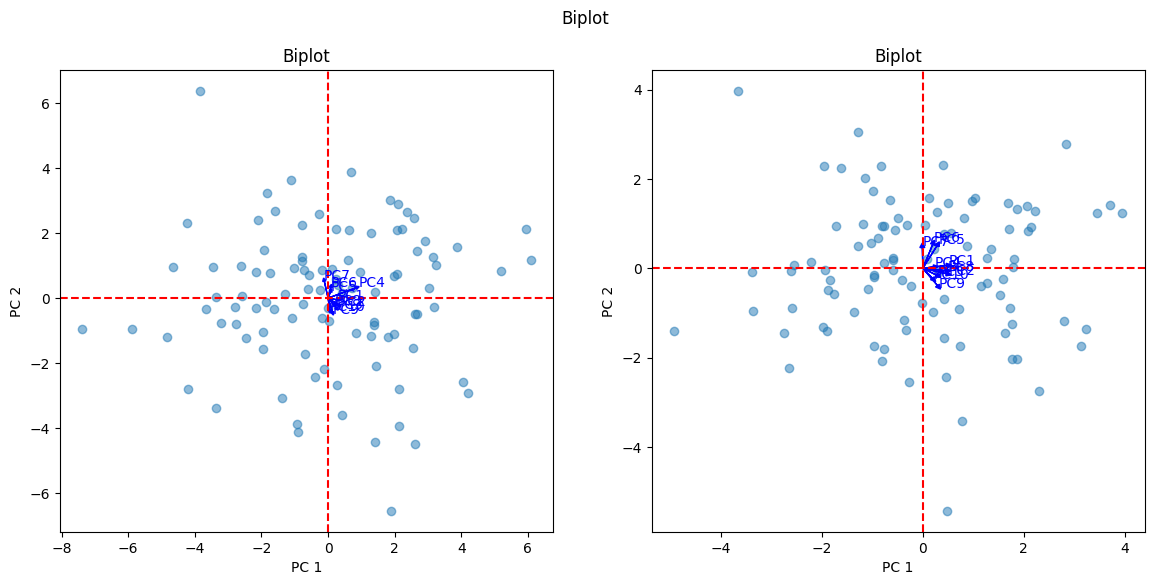

In [ ]:
# PCA 수행
pca1 = PCA()
pca1.fit(stocks_array)

pca2 = PCA()
pca2.fit(stocks_new)

# Screeplot 함수 정의
def screeplot(pca, ax):
    ax.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'o-', color='blue')
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Variance Explained')
    ax.set_title('Scree Plot')

# Biplot 함수 정의
def biplot(pca, data, ax):
    components = pca.components_.T
    transformed_data = pca.transform(data)
    ax.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.5)
    
    for i, (comp1, comp2) in enumerate(components[:, :2]):
        ax.arrow(0, 0, comp1, comp2, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
        ax.text(comp1 * 1.1, comp2 * 1.1, f'PC{i+1}', color='blue')

    ax.axhline(0, color='red', linestyle='--')
    ax.axvline(0, color='red', linestyle='--')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_title('Biplot')

# 시각화
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

screeplot(pca1, axs[0])
screeplot(pca2, axs[1])

fig.suptitle('Scree Plot')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

biplot(pca1, stocks_array, axs[0])
biplot(pca2, stocks_new, axs[1])

fig.suptitle('Biplot')
plt.show()

**biplot과 두 PCA**

biplot이란? 각 개체들의 첫번째 주성분(=행), 두번째 주성분(=열) 값을 나타내는 행렬도를 시각화 한것

1.  숫자는 데이터 그 자체를 의미
2.  Biplot 그림에서 화살표는 원변수와 PC의 상관계수를 뜻하며, PC와 평행할수록 해당 PC에 큰 영향.
3.  화살표 벡터의 길이가 원변수의 분산을 표현하며, 길수록 분산이 크다.


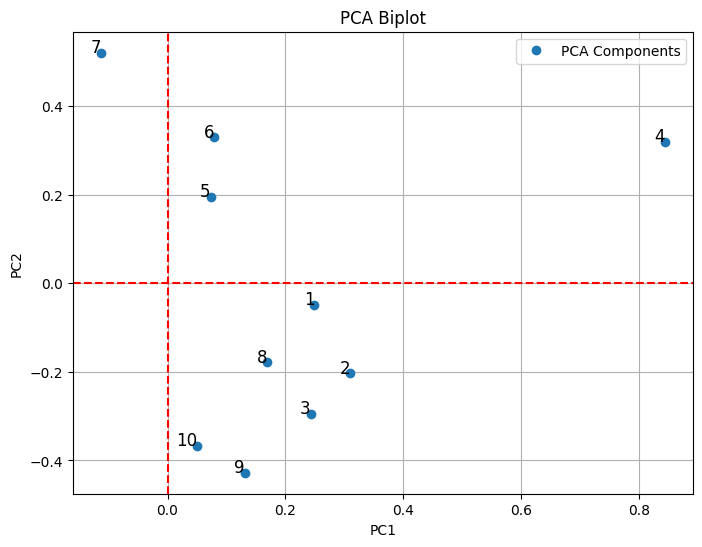

In [ ]:
# PCA 수행
pca1 = PCA()
pca1.fit(stocks_array)

# PCA의 첫 두 주성분
components = pca1.components_.T

# 시각화
plt.figure(figsize=(8, 6))

plt.plot(components[:, 0], components[:, 1], 'o', label='PCA Components')
for i in range(10):
    plt.text(components[i, 0], components[i, 1], str(i + 1), fontsize=12, ha='right')

plt.axhline(0, linestyle='--', color='red')
plt.axvline(0, linestyle='--', color='red')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot')
plt.legend()
plt.grid(True)
plt.show()

**결과 해석**

-   PC1에 가장 많은 영향을 미치는 요인은 comp1이다.
-   PC2에 가장 많은 영향을 미치는 요인은 comp10이다.
-   가장 분산이 큰 애는 comp4이다.

**생각해봐야 할 것**

-   주성분분석의 대상인 변수의 선정
-   제1주성분의 정의

**FA로 분석하기**

데이터 : 주식 주가지수

첫번째 4개 회사는 기술기업, 3개는 투자은행, 3개는 리테일.

**데이터 준비**

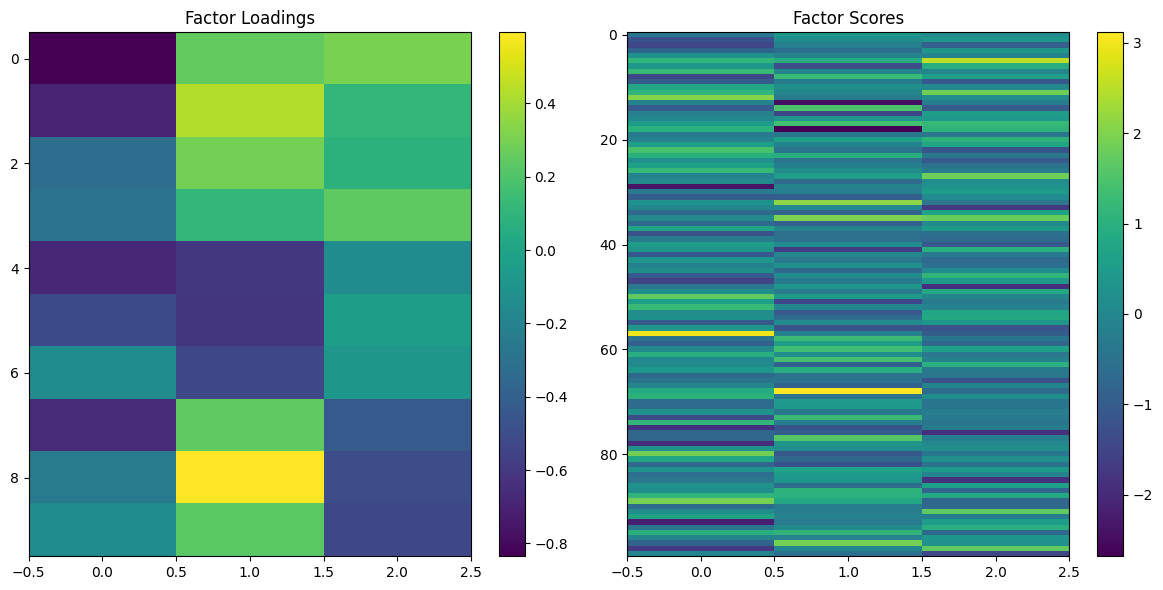

In [ ]:
# 요인 분석 수행
kval = 3
fa = FactorAnalysis(n_components=kval)
fa.fit(stocks_new)

# 요인 분석 결과
loadings = fa.components_.T

# 요인 점수 추출
# Note: `FactorAnalysis` in sklearn does not support score extraction like in R's `factanal`
# This part may need additional methods or libraries to fully replicate R's behavior.

# 요인 분석 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Factor Loadings')
plt.imshow(loadings, cmap='viridis', aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
# 요인 점수 시각화 (임시로 모든 데이터를 사용)
transformed_data = fa.transform(stocks_new)
plt.title('Factor Scores')
plt.imshow(transformed_data, cmap='viridis', aspect='auto')
plt.colorbar()

plt.tight_layout()
plt.show()

요인분석의 상관관계와 원 데이터의 상관관계를 보자.

In [ ]:

# 요인 분석 결과
loadings = fa.components_.T
transformed_data = fa.transform(stocks_new)

# 1. 요인 분석의 상관관계 vs 원 상관관계 비교
# 원본 데이터의 상관관계
correlation_original = np.corrcoef(stocks_new, rowvar=False)

# 요인 분석의 상관관계 (Fitted data의 공분산)
correlation_fa = np.corrcoef(transformed_data, rowvar=False)

# 상관관계 비교
print("Are factor analysis correlations close to original correlations?")
print(np.allclose(correlation_fa, correlation_original[:transformed_data.shape[1], :transformed_data.shape[1]]))

# 2. 분산 비교
var_stocks_new = np.var(stocks_new, axis=0)
var_loadings_squared = np.sum(loadings**2, axis=1)
uniquenesses = np.var(stocks_new, axis=0) - np.sum(loadings**2, axis=1)

# 비교
print("Are the variances and uniquenesses close?")
print(np.allclose(var_stocks_new - var_loadings_squared, uniquenesses))

Are factor analysis correlations close to original correlations?
False
Are the variances and uniquenesses close?
True


회전행렬을 통한 시각화를 해보자.

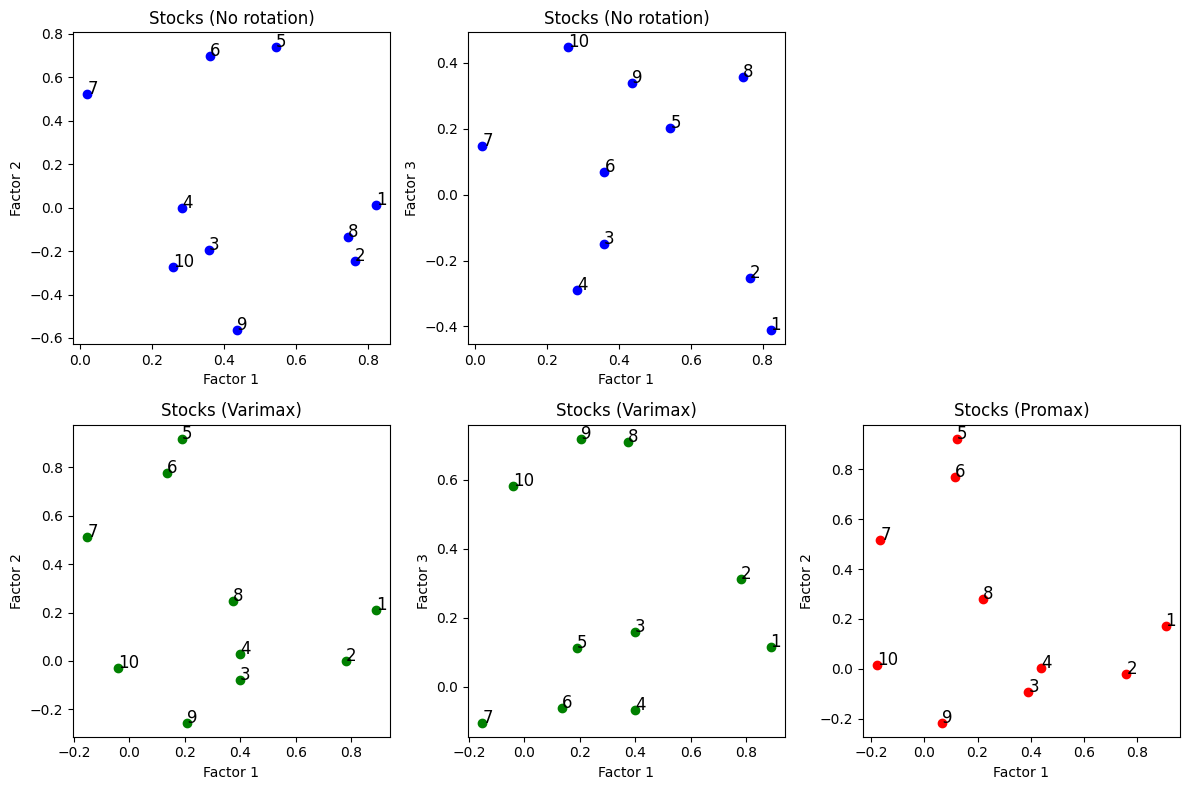

In [66]:
# 요인 분석 수행 (회전 없음)
kval = 3
fa = FactorAnalyzer(n_factors=kval, rotation=None)
fa.fit(stocks_new)
loadings = fa.loadings_

# Varimax 회전
fa_varimax = FactorAnalyzer(n_factors=kval, rotation='varimax')
fa_varimax.fit(stocks_new)
loadings_varimax = fa_varimax.loadings_

# Promax 회전
fa_promax = FactorAnalyzer(n_factors=kval, rotation='promax')
fa_promax.fit(stocks_new)
loadings_promax = fa_promax.loadings_

# 시각화
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.scatter(loadings[:, 0], loadings[:, 1], c='b')
plt.title('Stocks (No rotation)')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
for i in range(loadings.shape[0]):
    plt.text(loadings[i, 0], loadings[i, 1], str(i+1), fontsize=12)

plt.subplot(2, 3, 2)
plt.scatter(loadings[:, 0], loadings[:, 2], c='b')
plt.title('Stocks (No rotation)')
plt.xlabel('Factor 1')
plt.ylabel('Factor 3')
for i in range(loadings.shape[0]):
    plt.text(loadings[i, 0], loadings[i, 2], str(i+1), fontsize=12)

plt.subplot(2, 3, 4)
plt.scatter(loadings_varimax[:, 0], loadings_varimax[:, 1], c='g')
plt.title('Stocks (Varimax)')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
for i in range(loadings_varimax.shape[0]):
    plt.text(loadings_varimax[i, 0], loadings_varimax[i, 1], str(i+1), fontsize=12)

plt.subplot(2, 3, 5)
plt.scatter(loadings_varimax[:, 0], loadings_varimax[:, 2], c='g')
plt.title('Stocks (Varimax)')
plt.xlabel('Factor 1')
plt.ylabel('Factor 3')
for i in range(loadings_varimax.shape[0]):
    plt.text(loadings_varimax[i, 0], loadings_varimax[i, 2], str(i+1), fontsize=12)

plt.subplot(2, 3, 6)
plt.scatter(loadings_promax[:, 0], loadings_promax[:, 1], c='r')
plt.title('Stocks (Promax)')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
for i in range(loadings_promax.shape[0]):
    plt.text(loadings_promax[i, 0], loadings_promax[i, 1], str(i+1), fontsize=12)

plt.tight_layout()
plt.show()

**결과 해석**

1.  factor 2의 관점에서 보자. rotation을 해보면 리테일이 두드러져 보인다.

    factor 2가 리테일에 관련된 잠재요인임을 알 수 있다.

2.  factor 3의 관점에서 보자. rotation을 해보면, 투자은행이 두드러져 보인다.

    factor 3가 투자은행에 관련된 잠재요인임을 알 수 있다.

이러한 factor를 찾아냄으로써 연관된 (=같이 움직이는) 변수들을 찾을 수 있다.

-   추정된 람다를 바탕으로 factor score을 찾아냄.

In [71]:
# 요인 점수 계산
factor_scores = fa.transform(stocks_new)

# 요인 점수의 상관 행렬 계산
factor_scores_corr = np.corrcoef(factor_scores.T)

In [72]:
factor_scores_corr

array([[ 1.        ,  0.02987633, -0.02007141],
       [ 0.02987633,  1.        ,  0.04069608],
       [-0.02007141,  0.04069608,  1.        ]])

-   factor가 많으면 많을수록, 설명은 잘 되나 해석하기 힘듬
-   factor가 너무 적으면, 관계 설명이 너무 어려워짐.

# 정리 : PCA vs FA

-   주성분분석 : hclustering과 비슷.

-   요인분석 : d를 지정한다. k-means와 비슷

-   FA: 모델링 베이스. 안되는 걸 전부 error term으로

    -   $\mu$, $\Lambda$를 estimation

    -   결과를 하나 잡고, 제일 좋은 것을 선택.

        차원은 2개야! ⇒ 확인!

    -   따라서 답이 달라질 수 있음.

-   PCA: 분해 베이스. 수학적 방법을 사용

    -   행렬의 trace와 eigenvalue 사용

    -   결과는 나와있고, 이중에서 고르기

        차원 중 3개를 잡자! ⇒ 확인!

    -   따라서 답이 항상 1개

-   SVD, PCA, FA 모두 변수들을 줄이는 것이 목표.

    변수를 줄인다 = 연관성이 높은 변수를 찾아서 지울 것을 지운다.

-   **따라서, 먼저 표본공분산을 보면서 상관관계가 있는지를 봐야 함!**

    상관관계가 없으면 차원축소를 하는 의미가 없다.

    **상관관계가 있다 = 정보가 중복되어 있다.**
